<a href="https://colab.research.google.com/github/akashgardas/Machine-Learning/blob/clustering/Hierarchical_Clustering/Hierarchical_Clustering_SentimentAnalysis_FinancialNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Clustering on Financial News
# Sentiment Analysis for Financial News

- DataSource: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

## Scenario

A media company publishes **thousands of news articles daily**.

Problems they face:

- Articles are **not consistently tagged**
- Manual categorization is expensive
- New topics emerge frequently

The company wants to:

- Automatically **group similar news articles**
- Discover **hidden themes** without defining categories upfront
- Build a **content recommendation system**

They hire you as a **Data Analyst** to discover **natural article groupings** using data — *without knowing how many topics exist*.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

## 1. Load & Inspect Data

In [ ]:
path = '/content/drive/MyDrive/Tek works/ML Data Source/Kaggle/UnsupervisedLearning_Data/all-data.csv'
df = pd.read_csv(path, encoding='latin-1', names=['Sentiment', 'News']) # News Headline
df.head()

,Sentiment,News
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
df.shape

(4846, 3)

## 2. EDA

In [ ]:
# Check distribution of target value
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,2879
positive,1363
negative,604


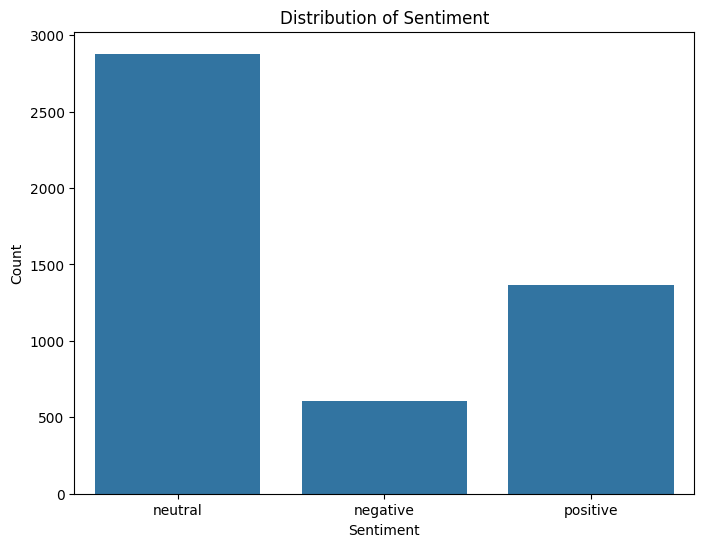

In [ ]:
# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

**Observation**:
- Dataset is imbalanced.
- The `neutral` class is dominant (approx 60%), followed by `positive` and then `negative`.

**Insights**:
- The model might be biased towards predicting `neutral`.

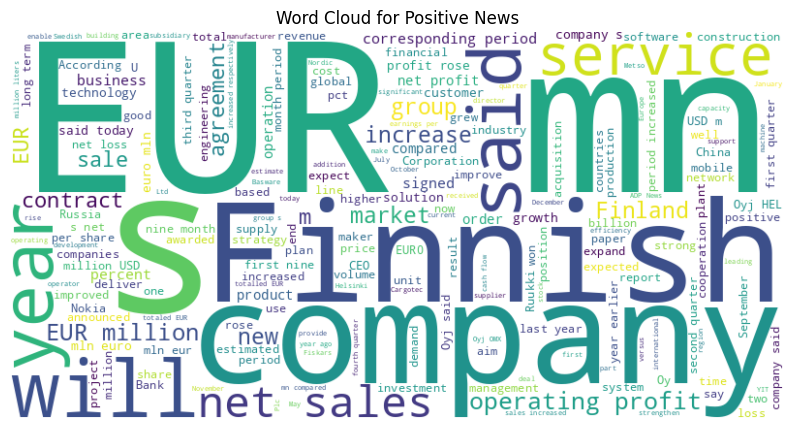

In [ ]:
# Generate Word Cloud for Positive News
positive_text = " ".join(df[df['Sentiment']=='positive']['News'])
wc = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive News')
plt.show()

## 3. Text Preprocessing

In [ ]:
# Define function to clean noise (numbers, punctuation, special characters) from financial news text.
def clean_text(text):
  text = text.lower() # Lowercase
  text = re.sub(r'\[.*?\]', '', text) # Remove text in brackets
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
  text = re.sub(r'\w*\d\w*', '', text) # Remove words with numbers
  return text

In [ ]:
# Apply the cleaning function
df['Clean_News'] = df['News'].apply(clean_text)

# Check the cleaned text
print(df[['News', 'Clean_News']].head())

                                                News  \
0  According to Gran , the company has no plans t...   
1  Technopolis plans to develop in stages an area...   
2  The international electronic industry company ...   
3  With the new production plant the company woul...   
4  According to the company 's updated strategy f...   

                                          Clean_News  
0  according to gran  the company has no plans to...  
1  technopolis plans to develop in stages an area...  
2  the international electronic industry company ...  
3  with the new production plant the company woul...  
4  according to the company s updated strategy fo...  


## 4. Feature Extraction (TF-IDF)
Term Frequency-Inverse Document Frequency



In [ ]:
# Initialize TF-IDF Vectoizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Transform the text data
X = tfidf.fit_transform(df['Clean_News'])
y = df['Sentiment']

In [ ]:
# Split into Training and Testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Sentiment Analysis (Supervised Learning)

In [ ]:
# Initialize and train model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

### 5.1 Model Evaluation

Accuracy: 0.7484536082474227

Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.43      0.56       110
     neutral       0.73      0.96      0.83       571
    positive       0.81      0.45      0.58       289

    accuracy                           0.75       970
   macro avg       0.78      0.61      0.66       970
weighted avg       0.76      0.75      0.72       970



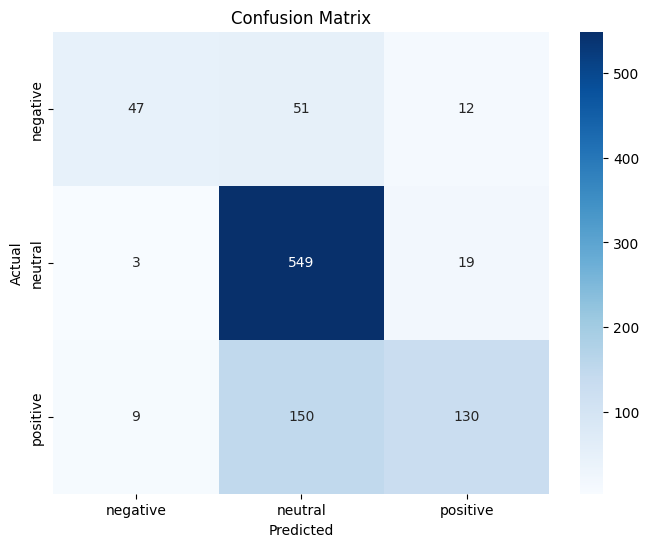

In [ ]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 5.2 Result Summary
- **Accuracy**: ~75%
- **Performace**: The model performs very well on `neutral` news (Recall ~96%) but struggles with `positive` and `negative` classes (Recall ~45%). This confirms the suspicion about class imbalance.

## 6. Hierarchical Clustering

In [ ]:
X = X.toarray()

# Sampling for Hierarchy
# Hierarchical clustering is computationally expensive (O(N^2)).
# We'll take a random sample of 2000 articles for demonstration.
df_sample = df.sample(n=2000, random_state=42).reset_index(drop=True)
X_sample = tfidf.transform(df_sample['Clean_News']).toarray()

print(f"Data shape for clustering: {X_sample.shape}")

Data shape for clustering: (2000, 5000)


### 6.1 Plot Dendrogram

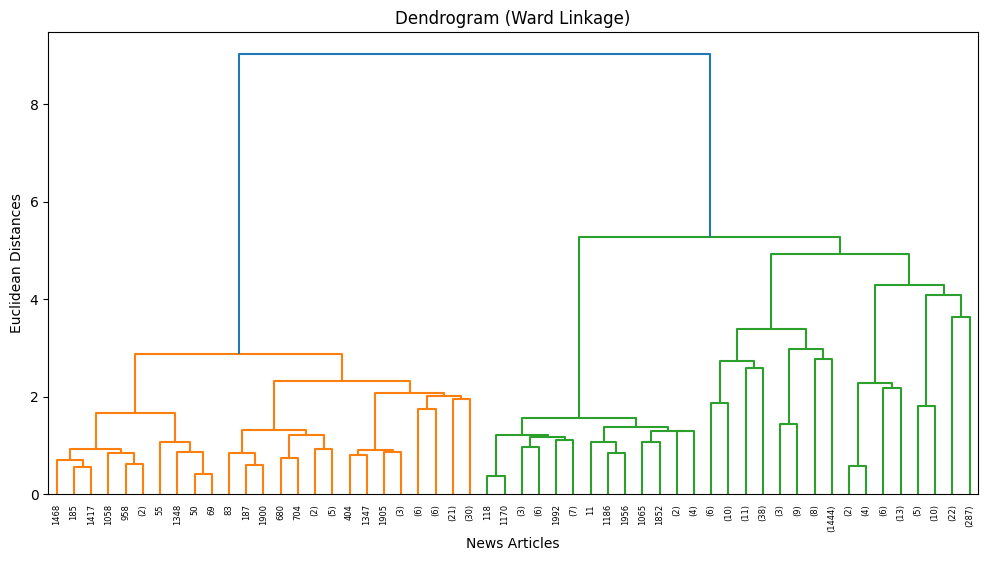

In [ ]:
# Plot Dendrogram
plt.figure(figsize=(12, 6))
plt.title("Dendrogram (Ward Linkage)")
plt.xlabel("News Articles")
plt.ylabel("Euclidean Distances")

# Using Ward's linkage method
# truncate_mode='level' simplifies the plot if there are too many leaves
dendrogram = sch.dendrogram(sch.linkage(X_sample, method='ward'), truncate_mode='level', p=5)
plt.show()

### 6.2 Fit Agglomerative Clustering

In [ ]:
# We choose 3 clusters based on our domain knowledge (Pos, Neg, Neu)
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_hc = hc.fit_predict(X_sample)

In [ ]:
# Add cluster labels to dataframe
df_sample['Cluster'] = y_hc

### 6.3 Evaluate with Cross-Tabulation

In [ ]:
# Compare the unsupervised clusters with the actual sentiment labels
crosstab = pd.crosstab(df_sample['Sentiment'], df_sample['Cluster'])
print("\nCross-tabulation of Sentiment vs Clusters:")
print(crosstab)


Cross-tabulation of Sentiment vs Clusters:
Cluster       0   1   2
Sentiment              
negative    199  37   2
neutral    1161  13  11
positive    518  42  17


### 6.4 Visualizing Clusters with PCA
Dimentionality Reduction

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

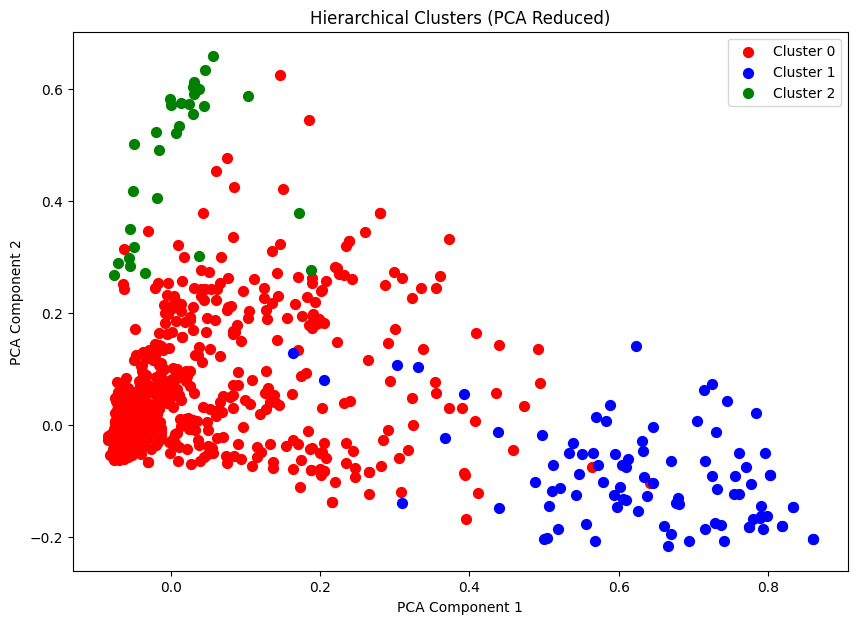

In [ ]:
plt.figure(figsize=(10, 7))
colors = ['red', 'blue', 'green']
for i in range(3):
    plt.scatter(X_pca[y_hc == i, 0], X_pca[y_hc == i, 1], s=50, c=colors[i], label=f'Cluster {i}')

plt.title('Hierarchical Clusters (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

### 6.5 Evalute Model
Silhouette score

In [ ]:
# silhouette score
silhouette_avg = silhouette_score(X_sample, y_hc)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.007648118780859778


### 6.6 Result Summary
- **Low score**: A score close to 0 means that the clusters are overlapping significantly. The data points are very close to decision boundary between clusters.